# Trend is not Dead

Diego Alvarez diego.alvarez@colorado.edu

# Packages

In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

# Collect Data & Prep Data

In [14]:
try:
    
    df = pd.read_parquet(
        path = "futures.parquet",
        engine = "pyarrow")
    
except: 
    
    tickers = pd.read_csv("tickers.csv")["Symbol"].dropna().drop_duplicates().to_list()
    
    start_date = dt.date(year = 1980, month = 1, day = 1)
    end_date = dt.date.today()
    
    df = (yf.download(
        tickers = tickers, start = start_date, end = end_date)[
        "Adj Close"].
        reset_index().
        melt(id_vars = "Date").
        dropna())
    
    df.to_parquet(
        path = "futures.parquet",
        engine = "pyarrow")

[*********************100%***********************]  37 of 37 completed


In [15]:
def _get_stats(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(
            rtn = lambda x: x.value.pct_change(),
            ma10  = lambda x: x.value.rolling(window = 10).mean(),
            ma100 = lambda x: x.value.rolling(window = 100).mean(),
            signal = lambda x: np.where(x.ma10 > x.ma100, 1, -1)))

In [19]:
df_stats = (df.groupby(
    "variable", group_keys = True).
    apply(_get_stats).
    dropna())

# Calculate lag and plot

In [20]:
def _shift(df: pd.DataFrame, shift_val: int = 1):
    return(df.assign(
        shifted_signal = lambda x: x.signal.shift(shift_val)))
 
df_shifted = (df_stats[
    ["Date", "variable", "rtn", "signal"]].
    groupby("variable", group_keys = True).
    apply(_shift).
    reset_index(drop = True).
    dropna())

In [21]:
df_rtn = (df_shifted.assign(
    lag0_rtn = lambda x: x.rtn * x.signal,
    lag1_rtn = lambda x: x.rtn * x.shifted_signal,
    spread = lambda x: x.lag1_rtn - x.lag0_rtn).
    query("variable != ['ES=F', 'MGC=F']"))

In [22]:
df_rtn_wider = (df_rtn[
    ["Date", "variable", "spread"]].
    pivot(index = "Date", columns = "variable", values = "spread"))

df_cum_wider = np.cumprod(1 + df_rtn_wider) - 1
df_cum_wider_avg = df_cum_wider.mean(axis = 1)

In [23]:
df_signal_rtn = (df_rtn[
    ["Date", "variable", "lag0_rtn", "lag1_rtn"]].
    pivot(index = "Date", columns = ["variable"], values = ["lag0_rtn", "lag1_rtn"]))

df_signal_cum = np.cumprod(1 + df_signal_rtn) - 1

df_cum_spread = (df_signal_cum.reset_index().melt(
    id_vars = "Date").
    rename(columns = {None: "lag"}).
    pivot(index = ["Date", "variable"], columns = "lag", values = "value").
    reset_index().
    dropna().
    assign(spread = lambda x: x.lag1_rtn - x.lag0_rtn)
    [["Date", "variable", "spread"]].
    pivot(index = "Date", columns = "variable", values = "spread"))

df_cum_spread_avg = df_cum_spread.mean(axis = 1)

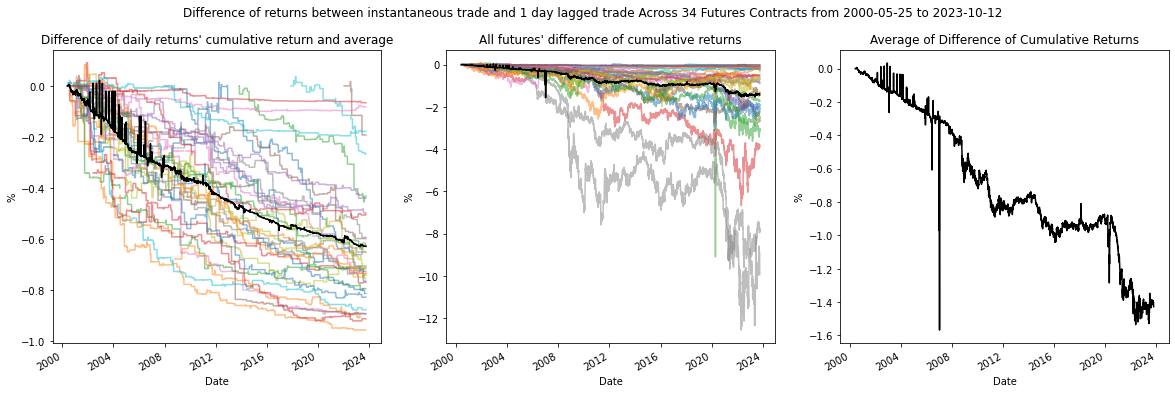

In [24]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

df_cum_wider.plot(
    alpha = 0.5,
    legend = False,
    ax = axes[0])

df_cum_wider_avg.plot(
    color = "black",
    ax = axes[0],
    ylabel = "%",
    title = "Difference of daily returns' cumulative return and average")

df_cum_spread.plot(
    alpha = 0.5,
    ax = axes[1],
    legend = False,
    ylabel = "%",
    title = "All futures' difference of cumulative returns")

df_cum_spread_avg.plot(
    ax = axes[1],
    color = "black",
    ylabel = "%")

df_cum_spread_avg.plot(
    ax = axes[2],
    color = "black",
    ylabel = "%",
    title = "Average of Difference of Cumulative Returns")

fig.suptitle("Difference of returns between instantaneous trade and 1 day lagged trade Across {} Futures Contracts from {} to {}".format(
    len(df_rtn_wider.columns.to_list()),
    df_rtn_wider.index.min().date(),
    df_rtn_wider.index.max().date()))

plt.show()

# Calculate Signal to market returns

In [51]:
def _make_signal(df: pd.DataFrame) -> pd.DataFrame:
    return(df.sort_values(
        "Date").
        assign(
            signal = lambda x: x.ma10 - x.ma100))

df_signal = (df_stats.drop(
    columns = ["signal"]).
    groupby("variable", group_keys = True).
    apply(_make_signal)
    [["Date", "variable", "value", "signal"]].
    pivot(index = "Date", columns = "variable", values = ["value", "signal"]).
    resample("Q").
    first().
    pct_change().
    reset_index().
    melt(id_vars = "Date", var_name = ["stat", "ticker"], value_name = "val").
    pivot(index = ["Date", "ticker"], columns = "stat", values = "val").
    reset_index().
    dropna())

<AxesSubplot:xlabel='value', ylabel='signal'>

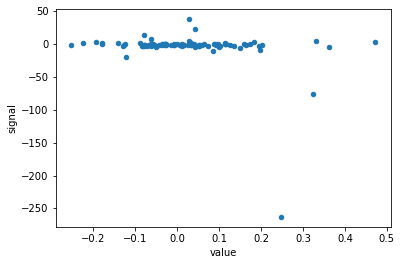

In [55]:
df_signal.query("ticker == 'CC=F'").plot(kind = "scatter", x = "value", y = "signal")